In [19]:
import numpy as np
import pandas as pd
from scipy.linalg import svd
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection


# Data preview / Cleaning

In [48]:
df = pd.read_csv('../dataset_mood_smartphone.csv')
df = df.drop('Unnamed: 0', axis = 1)
df[['day', 'time']] = df['time'].str.split(' ', expand=True)
df.head()
variables = df['variable'].unique()
ids = df['id'].unique()
days = df['day'].unique()
times = df['time'].unique()



## Tables creation

In [21]:
columns = ['number', 'min', 'max']
rows = ['id','time','day']
table = pd.DataFrame(index = rows,columns= columns)
low_range = df.min()
up_range = df.max()
table.loc['id'] = [ids.shape[0],low_range['id'], up_range['id']]
table.loc['day'] = [days.shape[0],low_range['day'], up_range['day']]
table.loc['time'] = [times.shape[0],low_range['time'], up_range['time']]
table

,number,min,max
id,27,AS14.01,AS14.33
time,333445,00:00:00.000,23:59:59.946
day,113,2014-02-17,2014-06-09


In [49]:
table_var = pd.DataFrame(index = [variables],columns= ['up_range', 'low_range'])
var_range = []
for i,var in enumerate(variables):
    data = df[df['variable'] == var]['value']
    var_range += [np.array([np.max(data),np.min(data)])]
for i,var in enumerate(variables):
    table_var.iloc[i] = var_range[i]

## Plots

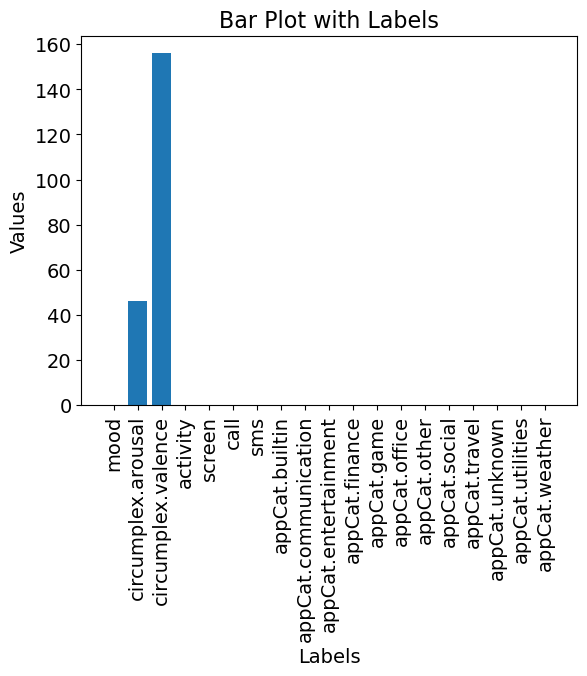

In [23]:
zeros_var = np.zeros(variables.shape[0])

for i,var in enumerate(variables):
    df_min = df[df['variable'] == var]
    zeros_var[i] = df_min.isna().sum().sum()

fig, ax = plt.subplots()


ax.bar(variables, zeros_var)

ax.set_xlabel('Labels')
ax.set_ylabel('Values')
ax.set_title('Bar Plot with Labels')
plt.xticks(rotation='vertical')

plt.show()

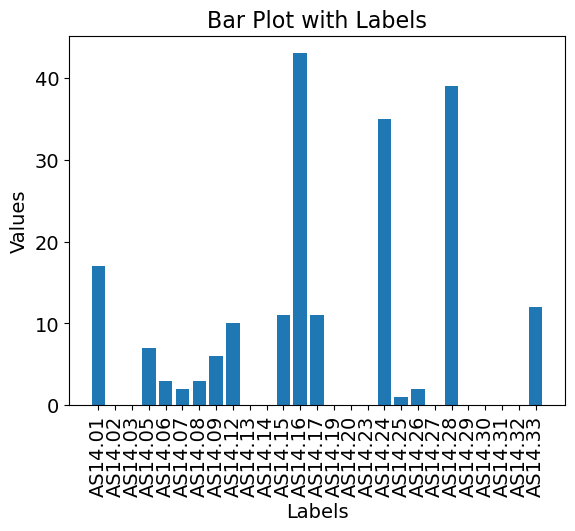

In [51]:
zeros_ids = np.zeros(ids.shape[0])

for i,var in enumerate(ids):
    df_min = df[df['id'] == var]
    zeros_ids[i] = df_min.isna().sum().sum()

fig, ax = plt.subplots()


ax.bar(ids, zeros_ids)

ax.set_xlabel('Labels')
ax.set_ylabel('Values')
ax.set_title('Bar Plot with Labels')
plt.xticks(rotation='vertical')

plt.show()

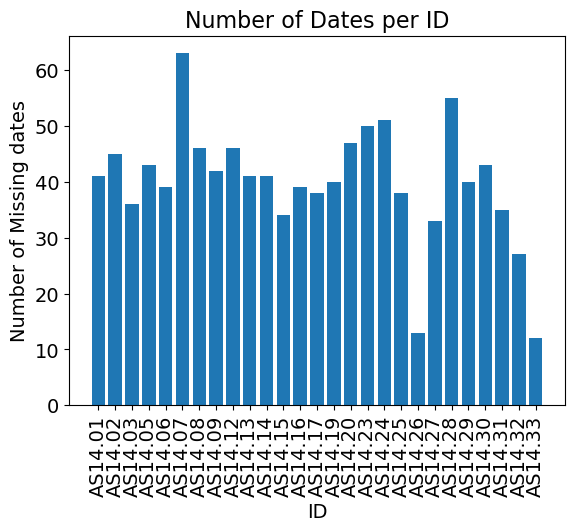

In [71]:
missing_dates = []

for id in ids:
    df_id = df[df['id'] == id]
    unique_dates_for_id = df_id['day'].unique()
    num_missing_dates = len(set(days) - set(unique_dates_for_id))
    
    missing_dates.append(num_missing_dates)

    
fig, ax = plt.subplots()
ax.bar(ids , missing_dates)

ax.set_xlabel('ID')
ax.set_ylabel('Number of Missing dates')
ax.set_title('Number of Dates per ID')
plt.xticks(rotation='vertical')

plt.show()

# Task: 1,B

## Moving average

In [6]:
def moving_average(data):
    while np.any(np.isnan(arr)):
        pos = np.argmax(np.isnan(data))
        data[pos] = np.mean(data[:pos])
    return data

In [7]:
print(variables)

['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']


In [ ]:
for i_d in ids:
    data_arousal = df[df['id'] == i_d]['circumplex.arousal']
    data_valence = df[df['id'] == i_d]['circumplex.valence']
    data_arousal = moving_average(data_arousal)
    data_valence = moving_average()